# Convolutional Neural Networks

## Introduction

How many weights are in a fully-connected classification neural network for MNIST digits that has 20 units in one hidden layer and 10 units in the output layer?

Each unit in hidden layer has 28 x 28 = 784 plus 1 weights, so the hidden layer has (784 + 1) x 20.  The output layer has (20 + 1) x 10 weights.

In [1]:
785 * 10

7850

In [2]:
785 * 20 + 21 * 10

15910

That's quite a few weights.  Can this number be reduced?  Remember, larger numbers of weights probably require more samples to train them.

Well, we could provide each hidden unit with just part of the image, such as a 10 x 10 patch.  We could assign each unit a random patch.  Then we would have (100 + 1) x 20 + 21 * 10 weights.

In [3]:
101 * 20 + 21 * 10

2230

In [4]:
2230 / 15910

0.14016341923318668

Wow, a little over one tenth the number of weights.

But this assignment of patches to each unit may end of missing parts of an image that are critical for correct classification.  We could add more units to cover more parts, but now our number of weights is growing.  Can we cover more parts of the image without increasing the number of weights in each unit and the number of units?

The answer, no surprise, is yes!  We can apply a hidden unit that receives 10 x 10 image patches to all 10 x 10 patches from an image.  Imagine that a unit has a lens that only sees a 10 x 10 patch.  That lens can be shifted around an image, each time passing the viewed patch through the unit and producing a scalar output.  Each of these outputs can be assembled into another image.

For our 10 x 10 unit, this would result in the following process.  Our 28 x 28 image of digits will result in a 2 x 2 set of 10 x 10 non-overlapping patches, with 8 pixels left over on right and bottom parts of the image.  Applying one hidden unit to these four patches produces four outputs that are arranged in a 2 x 2 image.  Each of these outputs represents how well the pattern in the unit's weights match the intensities in each patch.

This process of shifting the focus of a unit across an image is a [convolution](https://setosa.io/ev/image-kernels/).  The weights in a hidden unit are often called a kernel or a filter.

With 20 units in the hidden layer, we will have 20 much smaller images produced.  The weights in one unit might be values that result in the largest output when the patch has a vertical edge.  The weights in a second unit might be values that result in the largest output when the patch has a curve like a smile or like the bottom of a hand-drawn digit 3.

We now have a network with 2230 weights that can process an entire image, at the cost of some processing time to do the convolution and some storage for storing the smaller images as the output of a convolutional layer. For our simple example the additional computation and storage cost is small.

What if we allow overlapping patches?  Let's shift, or "stride", the lens of each unit by one pixel left-to-right, and top-to-bottom.  How many patches does this make?  Left-to-right gives us 28 - 10 + 1 = 19 patches, and similarly going top-to-bottom.  So each unit will be applied 19 x 19 times to produce a new image that is 19 x 19 = 361.  So, each hidden unit now produces 361 values. When we were not convolving, each unit produced 1 value, so the output layer received 20 values, one for each unit.  Now our output layer receives 361 values for each unit, or 361 x 20 = 7220 values.  

Anyway, let's move on to some actual examples of images, patches, and convolutions.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import pickle
import gzip

In [7]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape)

(50000, 784) (50000, 1) (10000, 784) (10000, 1) (10000, 784) (10000, 1)


In [8]:
Ttrain[:10]

array([[5],
       [0],
       [4],
       [1],
       [9],
       [2],
       [1],
       [3],
       [1],
       [4]])

In [9]:
Ttrain[7]

array([3])

In [10]:
three = Xtrain[7, :].reshape(28, 28)

Let's invert the values, so the bright 3 is dark, like an actual pencil drawing.

In [14]:
def draw_neg_image(image, label):
    plt.imshow(-image, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(label)

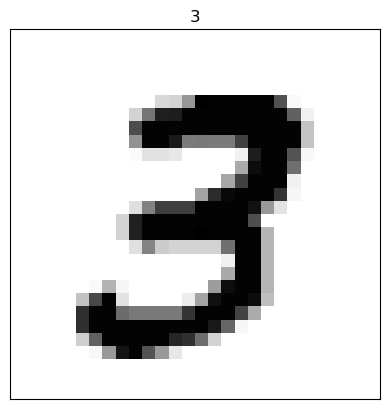

In [15]:
draw_neg_image(three, 3)

Instead of 10 x 10 patches, let's extract non-overlapping 7 x 7 patches from this image.  We can use two for loops: an inner loop to step across columns left-to-right and an outer loop to step down the rows top-to-bottom, and collect each patch into a list called `patches`.

In [16]:
patches = []
for row in range(0, 28, 7):
    for col in range(0, 28, 7):
        patches.append(three[row:row + 7, col:col + 7])
len(patches)

16

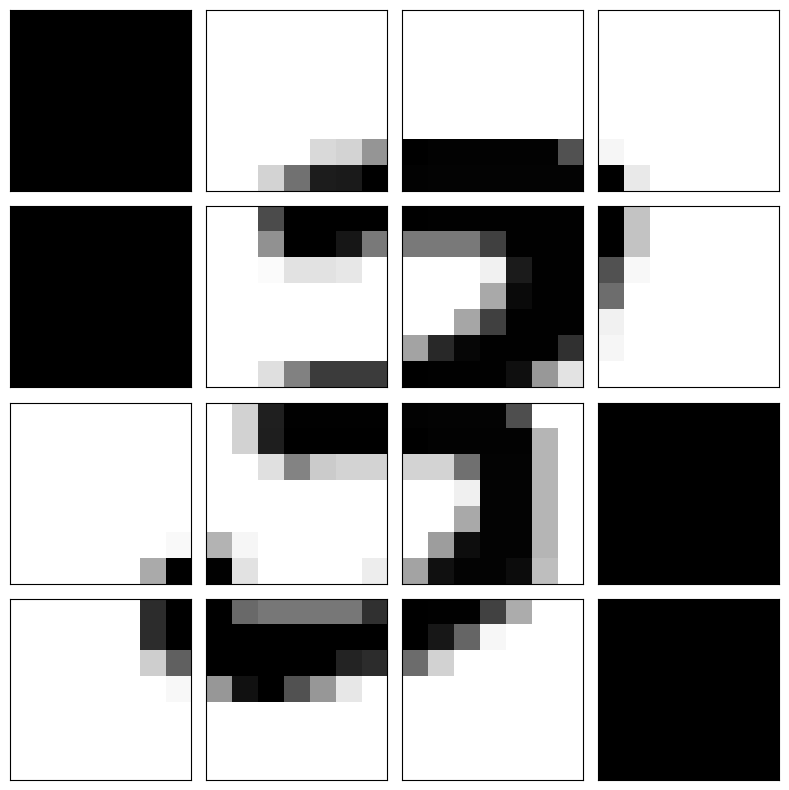

In [17]:
plt.figure(figsize=(8, 8))
ploti = 0
for patch in patches:
    ploti += 1
    plt.subplot(4, 4, ploti)
    draw_neg_image(patch, '')
plt.tight_layout()

In [18]:
def draw_neg_image(image, label):
    plt.imshow(-image, cmap='gray', vmin=-1, vmax=0)  # <-- New part
    plt.xticks([])
    plt.yticks([])
    plt.title(label)

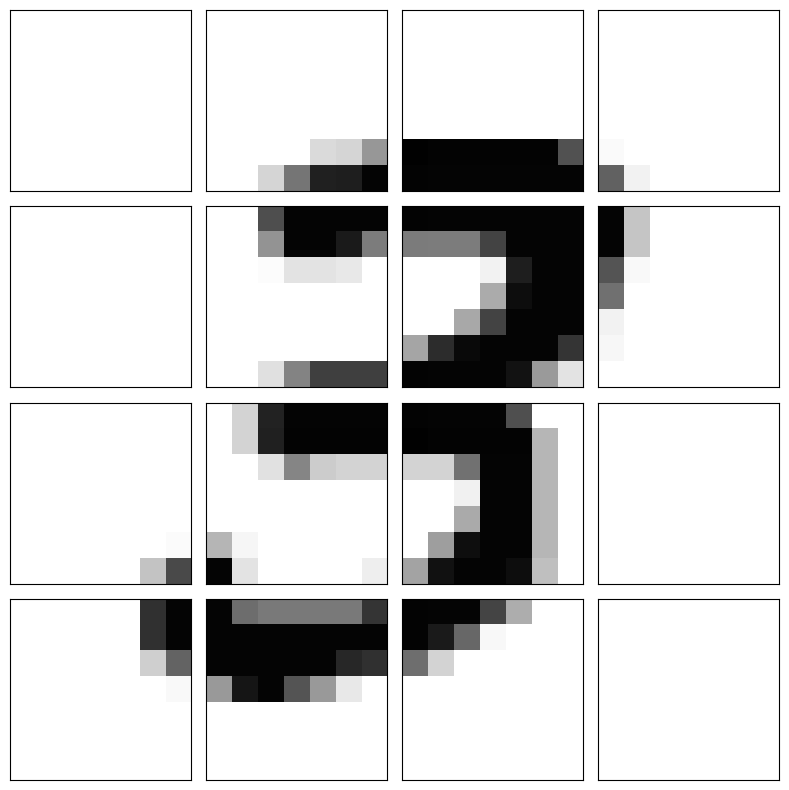

In [19]:
plt.figure(figsize=(8, 8))
ploti = 0
for patch in patches:
    ploti += 1
    plt.subplot(4, 4, ploti)
    draw_neg_image(patch, '')
plt.tight_layout()

Those all black patches are because all intensities there are 0.  Fix this by specifying min and max values to coloring each image.

What if we want some overlap?  7 x 7 patches that shift by 2 columns and 2 rows.

In [20]:
patches = []
for row in range(0, 28, 2):
    for col in range(0, 28, 2):
        patches.append(three[row:row + 7, col:col + 7])
len(patches)

196

In [21]:
np.sqrt(len(patches))

14.0

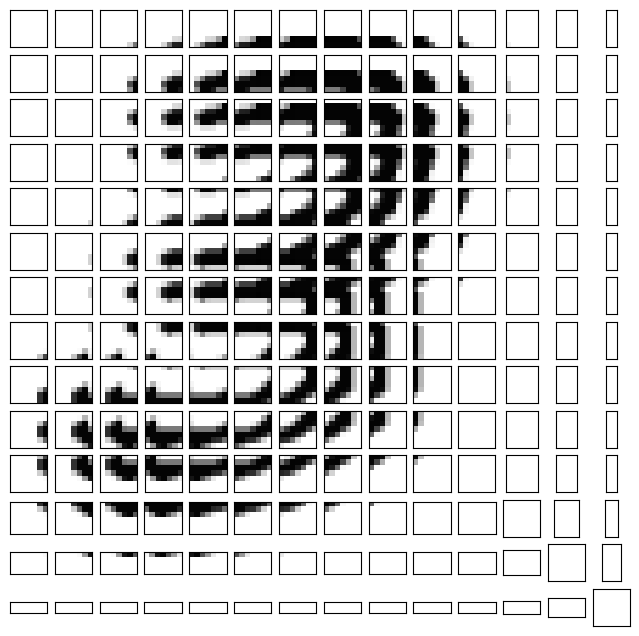

In [22]:
n_plot_rows = int(np.sqrt(len(patches)))
plt.figure(figsize=(8, 8))
ploti = 0
for patch in patches:
    ploti += 1
    plt.subplot(n_plot_rows, n_plot_rows, ploti)
    draw_neg_image(patch, '')

We will need all patches to be the same size, so we must discard the smaller ones on the right and the bottom.  Alternatively, we can pad the original image to guarantee all patches are the same size.

In [23]:
patches = []
for row in range(0, 28, 2):
    for col in range(0, 28, 2):
        if row + 7 < 28 and col + 7 < 28:
            patches.append(three[row:row + 7, col:col + 7])
len(patches)

121

In [24]:
np.sqrt(len(patches))

11.0

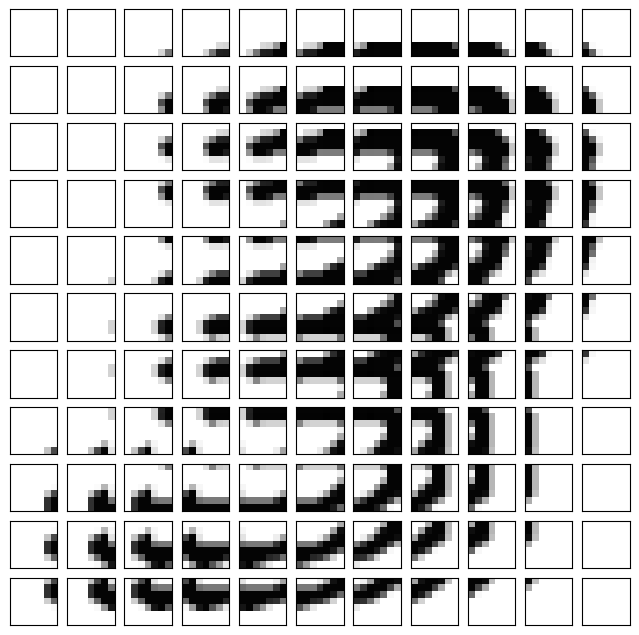

In [25]:
n_plot_rows = int(np.sqrt(len(patches)))
plt.figure(figsize=(8, 8))
ploti = 0
for patch in patches:
    ploti += 1
    plt.subplot(n_plot_rows, n_plot_rows, ploti)
    draw_neg_image(patch, '')

Are these patches using lots of storage, or are they just views onto the original image array?  Hopefully they are just views.  Test this by modifying the original image in the upper left corner and that redrawing the patches.

In [26]:
three[0:4, 0:4]

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)

In [27]:
three[0:4, 0:4] = 1.0

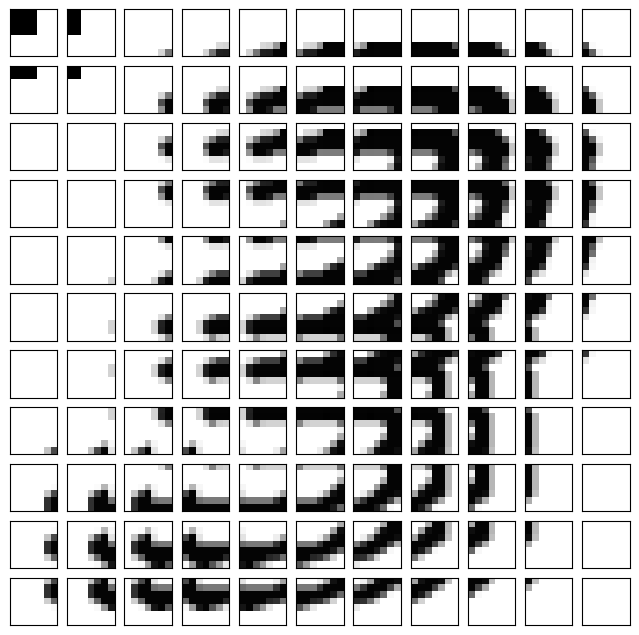

In [28]:
n_plot_rows = int(np.sqrt(len(patches)))
plt.figure(figsize=(8, 8))
ploti = 0
for patch in patches:
    ploti += 1
    plt.subplot(n_plot_rows, n_plot_rows, ploti)
    draw_neg_image(patch, '')

Yep, just views. Good!

Now let's reset those pixels.

In [29]:
three[0:4, 0:4] = 0.0

## Weight matrix as kernel or filter

Now, how would we create a unit as a kernel or filter and apply it to all patches?  

It is just a 7 x 7 matrix.  Let's make one that detects diagonal edges from lower left to upper right.

In [30]:
weights = np.array([[-1, -1, -1, -1, -1, -1, -1],
                    [-1, -1, -1, -1, -1, -1,  1],
                    [-1, -1, -1, -1, -1,  1,  1],
                    [-1, -1, -1, -1,  1,  1,  1],
                    [-1, -1, -1,  1,  1,  1,  1],
                    [-1, -1,  1,  1,  1,  1,  1],
                    [-1,  1,  1,  1,  1,  1,  1]])
weights

array([[-1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1,  1],
       [-1, -1, -1, -1, -1,  1,  1],
       [-1, -1, -1, -1,  1,  1,  1],
       [-1, -1, -1,  1,  1,  1,  1],
       [-1, -1,  1,  1,  1,  1,  1],
       [-1,  1,  1,  1,  1,  1,  1]])

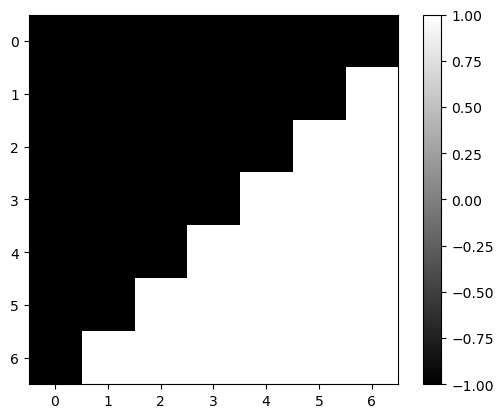

In [31]:
plt.imshow(weights, cmap='gray')
plt.colorbar();

Which of the above patches do you think will result in large positive values and large negative values.

Okay, let's apply this filter to all of the patches.  To do this, we just need to multiply the intensities in a patch by the corresponding weight and sum them up.

In [32]:
new_image = []
for patch in patches:
    new_image.append( np.sum(patch * weights) )
new_image = np.array(new_image)
new_image

array([  0.        ,   0.        ,   0.7109375 ,   2.78515625,
         6.1640625 ,   8.55859375,   9.3984375 ,   7.56640625,
         4.328125  ,   0.3828125 ,  -1.015625  ,   0.        ,
         0.        ,   3.80078125,   9.7265625 ,  13.00390625,
         9.80859375,   7.33203125,   6.828125  ,   3.02734375,
        -2.53125   ,  -3.8671875 ,   0.        ,   0.        ,
         3.9296875 ,   6.953125  ,   1.87890625,  -5.94140625,
        -4.44921875,  -0.90625   ,  -2.390625  , -10.3515625 ,
        -8.80859375,   0.        ,   0.        ,   1.1171875 ,
        -3.37109375, -10.13671875, -11.8671875 ,  -4.65234375,
         2.14453125,  -8.50390625, -17.91015625, -11.0859375 ,
         0.        ,   0.17578125,   1.328125  ,   2.67578125,
         4.921875  ,   5.38671875,  10.796875  ,   2.0703125 ,
       -14.62890625, -18.84765625,  -7.41015625,   0.        ,
         0.3515625 ,   5.27734375,  10.50390625,   8.62109375,
         6.91796875,   4.390625  ,  -7.3515625 , -17.42

Bleech.  Can't understand that.  Let's make it into an image and draw it.

In [33]:
new_image_dim = int(np.sqrt(len(new_image)))
new_image_dim

11

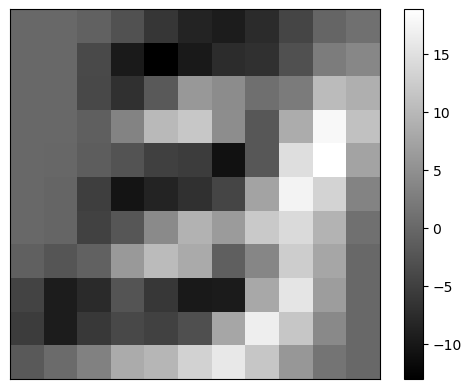

In [34]:
new_image = new_image.reshape(new_image_dim, new_image_dim)
draw_image(-new_image, '')
plt.colorbar();

We can apply our weights filter to all of the patches with one matrix multiplication!

In [35]:
new_image.shape

(11, 11)

In [36]:
len(patches), patches[0].shape

(121, (7, 7))

In [37]:
patches_array = np.array(patches)
patches_array.shape

(121, 7, 7)

In [38]:
weights.shape

(7, 7)

In [39]:
new_image = patches_array.reshape(121, -1) @ weights.reshape(-1, 1)
new_image.shape

(121, 1)

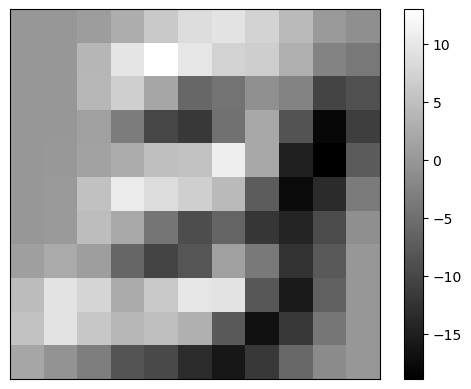

In [40]:
new_image = new_image.reshape(new_image_dim, new_image_dim)
draw_image(new_image, '')
plt.colorbar();

Now the idea is to come up with a number of such weight matrices to use as filters that extract the features of the image that are useful for classifying the digit.  How can we do this?

Each unit in the hidden layer is a convolutional unit with a 7 x 7 weight matrix, plus 1 weight for the constant 1 input.  Then we can just backpropagate an error from the output layer through the hidden convolutional layer to update each unit's weights, as we have been doing all along!

Backpropagation through a convolutional layer is tricky, because each unit is applied multiple times to all of the patches and we must sum up all of the resulting weight changes resulting from applying a unit to each patch.  This sum is then used to make the update to the weights.

Before we jump into code for doing this, let's revisit the method for dividing an image up into patches. We used two nested for loops, and we know for loops in python are slow.  Since convolution is a common procedure for many signal and image processing applications, the `numpy` function `numpy.lib.as_strided` function is available to do this. Thank the numpy developers! See [Using stride tricks with NumPy](https://ipython-books.github.io/46-using-stride-tricks-with-numpy/) for an example use.

In [41]:
import numpy.lib.stride_tricks

def make_patches(X, patch_size, stride=1):
    '''X: n_samples x n_pixels  (flattened square images)'''
    X = np.ascontiguousarray(X)  # make sure X values are contiguous in memory
    
    n_samples = X.shape[0]
    image_size = int(np.sqrt(X.shape[1]))
    n_patches = (image_size - patch_size ) // stride + 1
    
    nb = X.itemsize  # number of bytes each value

    new_shape = [n_samples, 
                 n_patches,  # number of rows of patches
                 n_patches,  # number of columns of patches
                 patch_size, # number of rows of pixels in each patch
                 patch_size] # number of columns of pixels in each patch
    
    new_strides = [image_size * image_size * nb,  # nuber of bytes to next image (sample)
                   image_size * stride * nb,      # number of bytes to start of next patch in next row
                   stride * nb,                   # number of bytes to start of next patch in next column
                   image_size * nb,               # number of bytes to pixel in next row of patch
                   nb]                            # number of bytes to pixel in next column of patch
    
    X = np.lib.stride_tricks.as_strided(X, shape=new_shape, strides=new_strides)
    
    # Reshape the set of patches to two-dimensional matrix, of shape  N x P x S,
    #   N is number of samples,  P is number of patches,  S is number of pixels per patch
    X = X.reshape(n_samples, n_patches * n_patches, patch_size * patch_size)
    
    return X

In [42]:
Xtrain.shape

(50000, 784)

Let's test this on the first two images.  Make patches of shape 7 x 7, with strides of 2 pixels.

In [43]:
patches = make_patches(Xtrain[:2], 7, 2)

In [44]:
patches.shape

(2, 121, 49)

In [45]:
11 * 11, 7 * 7

(121, 49)

Good.  2 images,  121 patches (11 x 11 patches), and 49 pixels per patch (7 x 7)

[5]
[0]


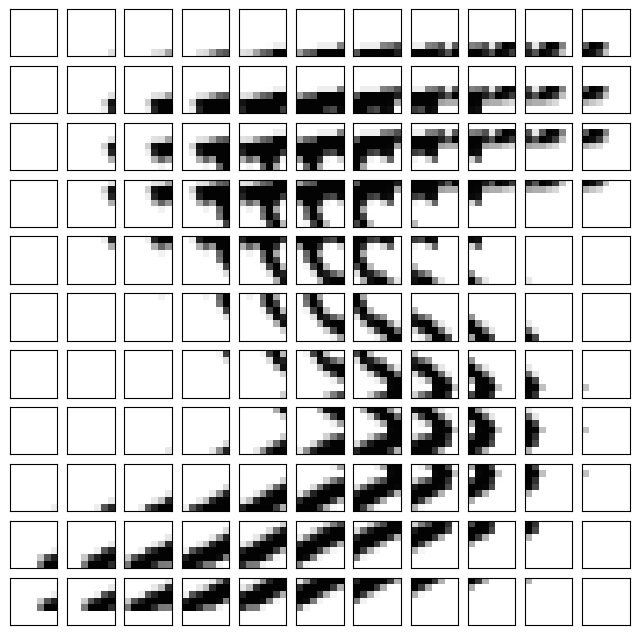

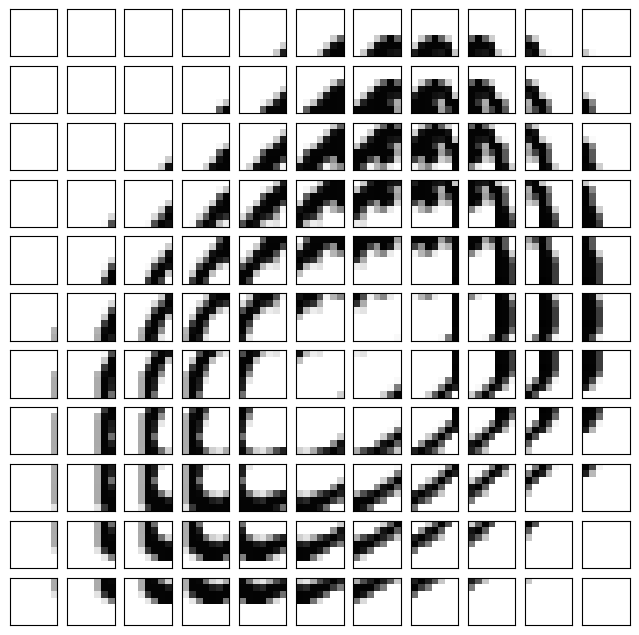

In [46]:
n_plot_rows = int(np.sqrt(patches.shape[1]))
patch_size = int(np.sqrt(patches.shape[2]))

for patchi in range(patches.shape[0]):
    print(Ttrain[patchi])
    plt.figure(figsize=(8, 8))
    ploti = 0
    for patch in patches[patchi, :, :]:
        ploti += 1
        plt.subplot(n_plot_rows, n_plot_rows, ploti)
        draw_neg_image(patch.reshape(patch_size, patch_size), '')

Remember our weights matrix?

In [47]:
weights.shape

(7, 7)

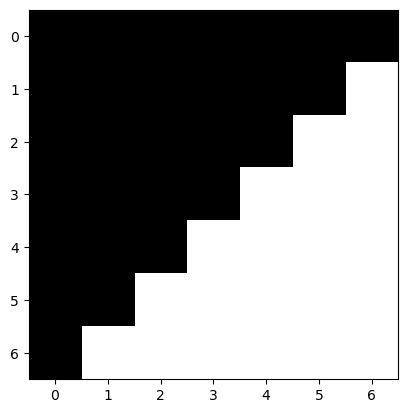

In [48]:
plt.imshow(weights, cmap='gray');

Let's make a second filter as the above one flipped vertically (over the rows).

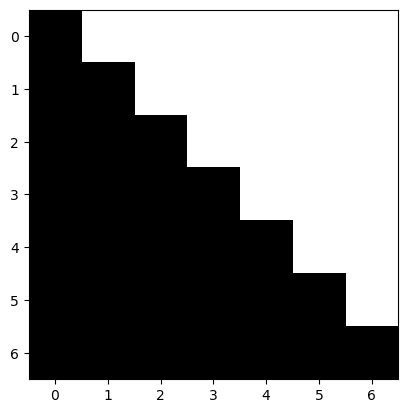

In [49]:
weights_flipped = np.flipud(weights)
plt.imshow(weights_flipped, cmap='gray');

In [50]:
weights = weights.reshape(49, 1)
weights.shape

(49, 1)

In [51]:
weights_flipped = weights_flipped.reshape(49, 1)
weights_flipped.shape

(49, 1)

In [52]:
weights_both = np.hstack((weights, weights_flipped))

In [53]:
weights_both.shape

(49, 2)

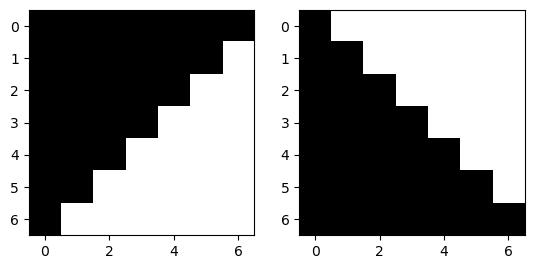

In [54]:
plt.subplot(1, 2, 1)
plt.imshow(weights_both[:, 0].reshape(7, 7), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(weights_both[:, 1].reshape(7, 7), cmap='gray');

In [55]:
patches.shape, weights_both.shape

((2, 121, 49), (49, 2))

In [56]:
output = patches @ weights_both
output.shape

(2, 121, 2)

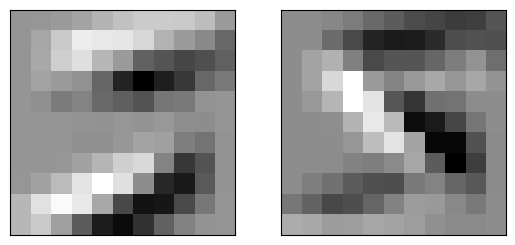

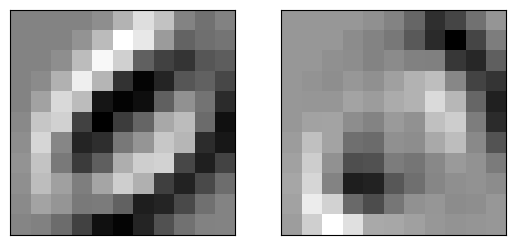

In [57]:
for i in range(2):
    plt.figure()
    for j in range(2):
        plt.subplot(1, 2, j+1)
        output_image = output[i, :, j].reshape(11, 11)
        draw_image(output_image, '')